In [1]:
import sys, os

#Our project root directory
PROJECT_ROOT = os.path.abspath(os.path.join(os.path.dirname("__file__"), os.pardir))
sys.path.append(PROJECT_ROOT)

#Local packages loaded from src specifying useful constants, and our custom loader
from util.constants import DATA_PATHS
from util.dataset import OcelotDatasetLoader, torch_to_image, seg_mask_from_dataloader
from util.unet import Unet

#other modules of interest
import torch
from torch.utils.data import DataLoader
from torchvision import transforms as transf
from PIL import Image
import numpy as np
from tqdm import tqdm

In [2]:
my_device = torch.device(device = 'cuda' if torch.cuda.is_available() else 'cpu')
pin_memory = True if my_device == 'cuda' else False
d_type_f32 = torch.float32
batch_size = 128
learning_rate= 1e-3
weight_decay = 1e-3
nepochs = 10
transforms = transf.Compose([transf.ToTensor()])

In [3]:
#Load our data in our special dataloader
TissTrainData = OcelotDatasetLoader(paths = DATA_PATHS, dataToLoad = 'Tissue', transforms=transforms)

#Establish a train/validation split size
TrainValSplit = [int(0.8*len(TissTrainData)), len(TissTrainData) - int(0.8*len(TissTrainData))]

#Establish our training and validation data using torch's built in random_split on our own formatted data
TrainingData, ValidationData = torch.utils.data.random_split(TissTrainData, TrainValSplit)

In [4]:
#Load into Pytorch's built in DataLoader
TissTrainLoader = DataLoader(TissTrainData, batch_size=batch_size, num_workers=4)
TissValLoader = DataLoader(ValidationData, batch_size=batch_size, num_workers=4)

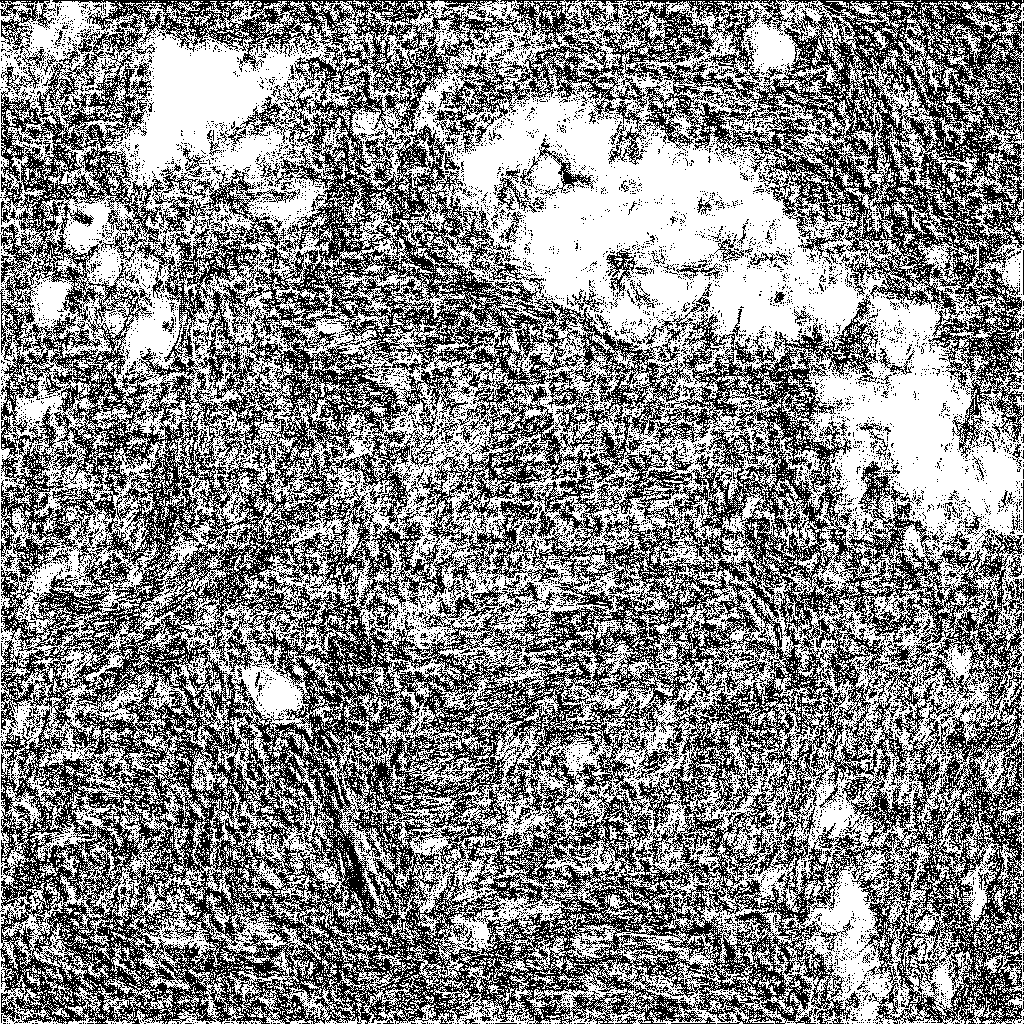

In [5]:
#Now let's see take some subset of our original data from data loader and see what our tissue mask looks like before training!
indices =  [0]
subset = torch.utils.data.Subset(TrainingData, indices)
MaskTestData = DataLoader(dataset = subset, batch_size=batch_size, num_workers=4)

#First we need to specify some info on our model: we have 3 channels RGB, 2 class: tissue, not tissue
model = Unet(n_channels=3, n_classes=2)
untrained_sample_masks = seg_mask_from_dataloader(model, MaskTestData, d_type_f32, my_device)
torch_to_image(untrained_sample_masks[0])

In [6]:
def tiss_training_loop(
    model,
    device,
    epochs,
    dtype,
    batch_size:         int = 1,
    learning_rate:      float = 1e-3,
    val_percent:        float = 0.1,        #TODO: What does?
    save_checkpoint:    bool = True,
    img_scale:          float = 1.0,
    amp:                bool = False,
    weight_decay:       float = 1e-3,
    momentum:           float = 0.999,
    gradient_clipping:  float = 1.0         #TODO: What does?
):
    transforms = transf.Compose([transf.ToTensor()])

    #Loading our data, performing necessary splits (update with test set in future), and send to loader
    print("Loading Ocelot dataset...")
    training_data = OcelotDatasetLoader(paths = DATA_PATHS, dataToLoad = 'Tissue', transforms=transforms)        
    train_val_split = [int(0.8*len(training_data)), len(training_data) - int(0.8*len(training_data))]
    train_split, val_split = torch.utils.data.random_split(training_data, train_val_split)
    train_loader = DataLoader(train_split, batch_size=batch_size, num_workers=4)
    val_loader = DataLoader(val_split, batch_size=batch_size, num_workers=4)   
    print(f"Found {len(training_data)} data samples.")   
    
    #Initialize logging???

    #Initialize optimizer, loss, learning rate, and loss scaling
    optimizer = torch.optim.SGD(model.parameters(), #or ADAM if time is factor?
                                lr=learning_rate,
                                momentum=momentum,
                                weight_decay=weight_decay)
    criterion = torch.nn.BCEWithLogitsLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5) #we use max here as our purpose is to maximize our measured metric (DICE score of 1 is better: more mask similarity)
    grad_scaler = torch.cuda.amp. #TODO

    #Begin training

    return

train = tiss_training_loop(model, my_device, 5, d_type_f32)

Loading Ocelot dataset...
Found 400 data samples.
